In [59]:
from DataUtils import DataInterface
import numpy as np;
import matplotlib.pyplot as plt;
from mpl_toolkits import mplot3d;

%matplotlib inline

In [66]:
class SensorReader:
    def __init__(self, radiusOfEarth, encoder_resolution, encoder_diameterL, encoder_diameterR):
        self.data_interface = DataInterface(
            # "/home/an/workspace/Classes/Spring 2022/CS-179/Project/urban16/sensor_data/gps.csv",
            # "/home/an/workspace/Classes/Spring 2022/CS-179/Project/urban16/sensor_data/xsens_imu.csv",
            # "/home/an/workspace/Classes/Spring 2022/CS-179/Project/urban16/sensor_data/encoder.csv"
            "C:/Users/erich/OneDrive/Desktop/UCI/CS 179/project/urban16/sensor_data/gps.csv",
            "C:/Users/erich/OneDrive/Desktop/UCI/CS 179/project/urban16/sensor_data/xsens_imu.csv",
            "C:/Users/erich/OneDrive/Desktop/UCI/CS 179/project/urban16/sensor_data/encoder.csv"
        )
        # data -> (lon,lat,alt,left,right,yaw,pitch,roll)
        self.R = radiusOfEarth
        self.res = encoder_resolution
        self.angle_to_rad = np.pi/180
        self.enc_radL = encoder_diameterL / 2
        self.enc_radR = encoder_diameterR / 2
        
        self.init_data, temp = self.parse(self.data_interface.read())
        self.meas = self.init_data.copy()
        self.meas[0:5] = 0 #re-init
        
    def parse(self, data):
        gps = data['gps_data']
        imu = data['imu_data']
        enc = data['encoders_data']
        lat,lon,alt = gps[1:4]
        pitch, roll, yaw = imu[5:8]
        left,right = enc[1:3]
        
        lat = lat*np.pi/180*R
        lon = lon*np.pi/180*R
        left = left * 2*np.pi/self.res * self.enc_radL
        right = right * 2*np.pi/self.res * self.enc_radR
        
        pitch = pitch * np.pi / 180
        yaw = yaw * np.pi / 180
        roll = roll * np.pi / 180

        #the second element is part fo the new cov for R
        return np.array([[lon,lat,alt,left,right,yaw,pitch,roll]]).T , gps[4:].reshape(3,3)
        #return np.array([[lon,lat,alt,left,right,yaw,pitch,roll]]).T
    def read(self):
        #self.meas, temp = self.parse(self.data_interface.read())
        self.meas, temp = self.parse(self.data_interface.read())
        self.meas[0:5] -= self.init_data[0:5]
        return self.meas, temp
        #return self.meas

In [67]:
class KalmanFilter:
    def __init__(self, A,C,Q,R, init0):
        self.A = A
        self.C = C
        self.Q = Q
        self.R = R

        self.mu = init0
        self.cov = np.eye(6)
        self.Kt = np.eye(6)
    def predict(self):
        self.mu_pred = self.A @ self.mu
        self.cov_pred = self.A @ self.cov @ self.A.T + self.R
        self.Kt = self.cov_pred @ self.C.T @ np.linalg.inv(self.C @ self.cov_pred @ self.C.T + self.Q)
    def correct(self, meas):
        self.mu = self.mu_pred + self.Kt @ (meas - self.C @ self.mu_pred)
        self.cov = (np.eye(6) - self.Kt@self.C) @ self.cov_pred

In [68]:

R = 6_371_000 #earth's radius in meters
encDiamL = 0.623022
encDiamR = 0.622356
res = 4096
wheelbase = 1.5285

sensors = SensorReader(R, res, encDiamL, encDiamR)

init0, temp = sensors.read()

In [72]:
print(init0[:3,:])

[[ 0.03335848]
 [-0.04447797]
 [ 0.062     ]]


In [69]:
A = np.zeros((6,6))
A[0:3, 0:3] = np.eye(3) * 2
A[0:3, 3:6] = np.eye(3) * -1
A[3:6, 0:3] = np.eye(3)


C = np.eye(6)

Q = np.zeros((6,6))
Q[0:3, 0:3] = temp * 2
Q[3:6, 3: 6] = temp

R = np.zeros((6,6))
R[0:3, 0:3] = temp
R[3:6, 3:6] = temp


start_mu = np.concatenate((init0[:3,:], np.zeros((3,1)) ), axis=0)
kal = KalmanFilter(A,C,Q,R,start_mu)

In [73]:
data = np.array([[0,0,0]]).T
sensor_data = np.array([[0,0,0]]).T
previous = np.array([[0,0,0]]).T

for i in range(5_000):
    reading, temp = sensors.read()
    kal.predict()
    kal.correct(np.concatenate((reading[:3,:], previous), axis = 0 ))
    previous = reading[:3,:]
    data = np.hstack((data,kal.mu[0:3,:]))
    sensor_data = np.hstack((sensor_data, reading[:3,:]))

C:\Users\erich\AppData\Local\Temp/ipykernel_30972/1860778617.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([[lon,lat,alt,left,right,yaw,pitch,roll]]).T , gps[4:].reshape(3,3)


In [75]:
data.shape

(3, 5001)

In [76]:
print(data)

[[0 array([[-5099894.36098918, -5099924.43112476, -5099924.43112476,
            -5099924.43112476, -5099924.43112476, -5099924.43112476],
           [-5099924.43112476, -5099894.36098918, -5099924.43112476,
            -5099924.43112476, -5099924.43112476, -5099924.43112476],
           [-5099924.43112476, -5099924.43112476, -5099898.85937476,
            -5099924.43112476, -5099924.43112476, -5099924.43112476],
           [-5099924.43112476, -5099924.43112476, -5099924.43112476,
            -5099894.36098918, -5099924.43112476, -5099924.43112476],
           [-5099924.43112476, -5099924.43112476, -5099924.43112476,
            -5099924.43112476, -5099894.36098918, -5099924.43112476],
           [-5099924.43112476, -5099924.43112476, -5099924.43112476,
            -5099924.43112476, -5099924.43112476, -5099898.85937476]])
  array([[-14362816.05200676, -14362900.73843229, -14362900.73843229,
          -14362900.73843229, -14362900.73843229, -14362900.73843229],
         [-14362900.7384

In [77]:
data[0,:].shape

(5001,)

In [82]:
print(data[0,1])

[[-5099894.36098918 -5099924.43112476 -5099924.43112476 -5099924.43112476
  -5099924.43112476 -5099924.43112476]
 [-5099924.43112476 -5099894.36098918 -5099924.43112476 -5099924.43112476
  -5099924.43112476 -5099924.43112476]
 [-5099924.43112476 -5099924.43112476 -5099898.85937476 -5099924.43112476
  -5099924.43112476 -5099924.43112476]
 [-5099924.43112476 -5099924.43112476 -5099924.43112476 -5099894.36098918
  -5099924.43112476 -5099924.43112476]
 [-5099924.43112476 -5099924.43112476 -5099924.43112476 -5099924.43112476
  -5099894.36098918 -5099924.43112476]
 [-5099924.43112476 -5099924.43112476 -5099924.43112476 -5099924.43112476
  -5099924.43112476 -5099898.85937476]]


In [83]:
data[0,1].shape

(6, 6)

ValueError: x and y must be the same size

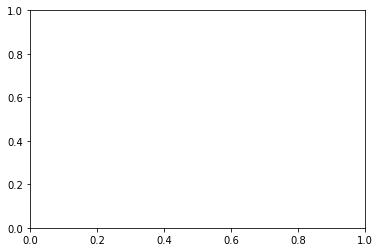

In [78]:
for i in range(1000):
    plt.scatter(data[0:i], data[1,i])

plt.show()

ValueError: setting an array element with a sequence.

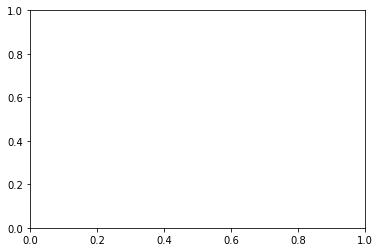

In [74]:
plt.scatter(data[0,:], data[1,:],c='red')
plt.show()